# Introduction

In this workshop, we will go through the steps of training and deploying a **network traffic classification model**.  We will show how to train two version of models where we will deploy them to a production and shadow variant.  We will use SageMaker Shadow Tests to help manage the test between the production and shadow variants.  

## Contents

1) [Setup](#setup)
2) [Basic Training](#basic_training)
3) [Register the Models](#register)
4) [Create Endpoint Config](#create_endpoint)
5) [Deploy and Predict](#deploy)
6) [Create a Shadow Test](#shadow)
7) [Evaluate](#eval)

For training our model we will be using datasets <a href="https://registry.opendata.aws/cse-cic-ids2018/">CSE-CIC-IDS2018</a> by CIC and ISCX which are used for security testing and malware prevention.
These datasets include a huge amount of raw network traffic logs, plus pre-processed data where network connections have been reconstructed and  relevant features have been extracted using CICFlowMeter, a tool that outputs network connection features as CSV files. Each record is classified as benign traffic, or it can be malicious traffic, with a total number of 15 classes.

Starting from this featurized dataset, we have executed additional pre-processing for the purpose of this lab:
<ul>
    <li>Encoded class labels</li>
    <li>Replaced invalid string attribute values generated by CICFlowMeter (e.g. inf and Infinity)</li>
    <li>Executed one hot encoding of discrete attributes</li>
    <li>Remove invalid headers logged multiple times in the same CSV file</li>
    <li>Reduced the size of the featurized dataset to ~1.3GB (from ~6.3GB) to speed-up training, while making sure that all classes are well represented</li>
    <li>Executed stratified random split of the dataset into training (80%) and validation (20%) sets</li>
</ul>

Class are represented and have been encoded as follows (train + validation):


| Label                    | Encoded | N. records |
|:-------------------------|:-------:|-----------:|
| Benign                   |    0    |    1000000 |
| Bot                      |    1    |     200000 |
| DoS attacks-GoldenEye    |    2    |      40000 |
| DoS attacks-Slowloris    |    3    |      10000 |
| DDoS attacks-LOIC-HTTP   |    4    |     300000 |
| Infilteration            |    5    |     150000 |
| DDOS attack-LOIC-UDP     |    6    |       1730 |
| DDOS attack-HOIC         |    7    |     300000 |
| Brute Force -Web         |    8    |        611 |
| Brute Force -XSS         |    9    |        230 |
| SQL Injection            |   10    |         87 |
| DoS attacks-SlowHTTPTest |   11    |     100000 |
| DoS attacks-Hulk         |   12    |     250000 |
| FTP-BruteForce           |   13    |     150000 |
| SSH-Bruteforce           |   14    |     150000 |       

The final pre-processed dataset has been saved to a public Amazon S3 bucket for your convenience, and will represent the inputs to the training processes.
<a id='setup'></a>
### Let's get started!

First, we set some variables, including the AWS region we are working in, the IAM (Identity and Access Management) execution role of the notebook instance and the Amazon S3 bucket where we will store data, models, outputs, etc. We will use the Amazon SageMaker default bucket for the selected AWS region, and then define a key prefix to make sure all objects have share the same prefix for easier discoverability.

In [2]:
%pip install jsonlines
%pip install sagemaker --upgrade


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.1/684.1 kB 6.7 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Created wheel for sagemaker: filename=sagemaker-2.138.0-py2.py3-none-any.whl size=925036 sha256=1bff86703f289c80f7f40c867951ca69290675307e13f4bc3fdf34e215725719
  Stored in directory: /root/.cache/pip/wheels/44/ab/87/4a3916930e33bf802035cf79bdf0dd51602ed1ad501a281bca
Successfully built sagemaker
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.135.1.post0
    Uninstalling sagemaker-2.135.1.post0:
      Successfully uninstalled sagemaker-2.135.1.post0

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import time
import glob
import json
import jsonlines
import base64

import boto3
import sagemaker
from sagemaker.model_monitor import DataCaptureConfig
from sagemaker.sklearn.estimator import SKLearn

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from IPython.display import display, clear_output

pd.options.display.max_columns = 100

region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
bucket_name = sagemaker.Session().default_bucket()
prefix = 'xgboost-webtraffic'
os.environ["AWS_REGION"] = region

print(f'REGION:  {region}')
print(f'ROLE:    {role}')
print(f'BUCKET:  {bucket_name}')

# These are the clasifications that have been encoded as ints, we'll use these for analysis
class_list = ['Benign','Bot','DoS attacks-GoldenEye','DoS attacks-Slowloris','DDoS attacks-LOIC-HTTP','Infilteration','DDOS attack-LOIC-UDP','DDOS attack-HOIC','Brute Force-Web','Brute Force-XSS','SQL Injection','DoS attacks-SlowHTTPTest','DoS attacks-Hulk','FTP-BruteForce','SSH-Bruteforce']

REGION:  us-east-1
ROLE:    arn:aws:iam::431615879134:role/sagemaker-test-role
BUCKET:  sagemaker-us-east-1-431615879134


#### Now we can copy the dataset from the public Amazon S3 bucket to the Amazon SageMaker default bucket used in this workshop. To do this, we will leverage on the AWS Python SDK (boto3) as follows:

In [4]:
s3 = boto3.resource('s3')

source_bucket_name = "endtoendmlapp"
source_bucket_prefix = "aim362/data/"
source_bucket = s3.Bucket(source_bucket_name)

In [4]:


for s3_object in source_bucket.objects.filter(Prefix=source_bucket_prefix):
    copy_source = {
        'Bucket': source_bucket_name,
        'Key': s3_object.key
    }
    print('Copying {0} ...'.format(s3_object.key))
    s3.Bucket(bucket_name).copy(copy_source, prefix+'/data/'+s3_object.key.split('/')[-2]+'/'+s3_object.key.split('/')[-1].replace('.part','.csv'))
    
print(f'Data copy from source bucket, {source_bucket_name}/{source_bucket_prefix}, to destination bucket {bucket_name}/{prefix}/data/, complete!')

Copying aim362/data/train/0.part ...
Copying aim362/data/train/1.part ...
Copying aim362/data/train/2.part ...
Copying aim362/data/train/3.part ...
Copying aim362/data/train/4.part ...
Copying aim362/data/train/5.part ...
Copying aim362/data/train/6.part ...
Copying aim362/data/train/7.part ...
Copying aim362/data/train/8.part ...
Copying aim362/data/train/9.part ...
Copying aim362/data/val/0.part ...
Copying aim362/data/val/1.part ...
Copying aim362/data/val/2.part ...
Copying aim362/data/val/3.part ...
Copying aim362/data/val/4.part ...
Copying aim362/data/val/5.part ...
Copying aim362/data/val/6.part ...
Copying aim362/data/val/7.part ...
Copying aim362/data/val/8.part ...
Copying aim362/data/val/9.part ...
Data copy from source bucket, endtoendmlapp/aim362/data/, to destination bucket sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/, complete!


Let's download some of the data to the notebook to quickly explore the dataset structure:

# Data

In [5]:
train_file_path = 's3://' + bucket_name + '/' + prefix + '/data/train/0.csv'
val_file_path = 's3://' + bucket_name + '/' + prefix + '/data/val/'

print(train_file_path)
print(val_file_path)

s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/train/0.csv
s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/


In [6]:
!mkdir -p data/train/ data/val/
!aws s3 cp {train_file_path} data/train/ 
!aws s3 cp {val_file_path} data/val/ --recursive

download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/train/0.csv to data/train/0.csv
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/0.csv to data/val/0.csv
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/1.csv to data/val/1.csv
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/2.csv to data/val/2.csv
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/4.csv to data/val/4.csv
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/5.csv to data/val/5.csv
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/6.csv to data/val/6.csv
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/3.csv to data/val/3.csv
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/7.csv to data/val/7.csv
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/val/9.csv to data/val/9.

In [7]:
df = pd.read_csv('data/train/0.csv')
df

,Target,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,day,month,year,dayofweek,prot_0,prot_6,prot_17
0,0,445,64443,5,4,373,172,140,0,74.600000,70.283711,133,0,43.000000,62.753486,8457.086107,139.658303,8.055375e+03,1.105582e+04,21474,3,64403,1.610075e+04,1.073215e+04,21537,3,64398,2.146600e+04,129.201393,21547,21317,0,0,0,0,112,92,77.587946,62.070357,0,140,54.500000,64.198044,4121.388889,0,0,0,1,0,0,0,0,0.0,60.555556,74.600000,43.000000,0.0,0.0,0.0,0.0,0.0,0.0,5,373,4,172,8192,0,3,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0
1,12,80,1527,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,1309.757695,1.527000e+03,0.000000e+00,1527,1527,1527,1.527000e+03,0.000000e+00,1527,1527,0,0.000000e+00,0.000000,0,0,0,0,0,0,64,0,1309.757695,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,225,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,16,2,2018,4,0,1,0
2,7,80,5573,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,358.873138,5.573000e+03,0.000000e+00,5573,5573,5573,5.573000e+03,0.000000e+00,5573,5573,0,0.000000e+00,0.000000,0,0,0,0,0,0,40,0,358.873138,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,32738,-1,0,20,0.0,0.0,0,0,0.0,0.0,0,0,21,2,2018,2,0,1,0
3,12,80,44934,2,0,0,0,0,0,0.000000,0.000000,0,0,0.000000,0.000000,0.000000,44.509725,4.493400e+04,0.000000e+00,44934,44934,44934,4.493400e+04,0.000000e+00,44934,44934,0,0.000000e+00,0.000000,0,0,0,0,0,0,64,0,44.509725,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,225,-1,0,32,0.0,0.0,0,0,0.0,0.0,0,0,16,2,2018,4,0,1,0
4,0,443,60108569,4,2,148,252,74,0,37.000000,42.723920,126,126,126.000000,0.000000,6.654625,0.099819,1.202171e+07,2.677679e+07,59921494,44882,60108569,2.003619e+07,3.454169e+07,59921494,93516,60013670,6.001367e+07,0.000000,60013670,60013670,1,0,0,0,80,40,0.066546,0.033273,0,126,67.714286,51.774235,2680.571429,0,1,0,0,1,0,0,0,0.0,79.000000,37.000000,126.000000,0.0,0.0,0.0,0.0,0.0,0.0,4,148,2,252,257,7010,1,20,93559.0,0.0,93559,93559,59921494.0,0.0,59921494,59921494,20,2,2018,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212208,14,22,298760,21,21,1912,2665,640,0,91.047619,139.679088,976,0,126.904762,263.574639,15319.989289,140.581068,7.286829e+03,2.230386e+04,122248,2,298722,1.493610e+04,3.049364e+04,122248,320,298752,1.493760e+04,33997.036726,126346,7,0,0,0,0,680,680,70.290534,70.290534,0,976,106.441860,207.291869,42969.919158,0,0,0,1,0,0,0,0,1.0,108.976190,91.047619,126.904762,0.0,0.0,0.0,0.0,0.0,0.0,21,1912,21,2665,26883,230,16,32,0.0,0.0,0,0,0.0,0.0,0,0,14,2,2018,2

In [8]:
df.isnull().sum()

Target           0
Dst Port         0
Flow Duration    0
Tot Fwd Pkts     0
Tot Bwd Pkts     0
                ..
year             0
dayofweek        0
prot_0           0
prot_6           0
prot_17          0
Length: 85, dtype: int64

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212213 entries, 0 to 212212
Data columns (total 85 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Target             212213 non-null  int64  
 1   Dst Port           212213 non-null  int64  
 2   Flow Duration      212213 non-null  int64  
 3   Tot Fwd Pkts       212213 non-null  int64  
 4   Tot Bwd Pkts       212213 non-null  int64  
 5   TotLen Fwd Pkts    212213 non-null  int64  
 6   TotLen Bwd Pkts    212213 non-null  int64  
 7   Fwd Pkt Len Max    212213 non-null  int64  
 8   Fwd Pkt Len Min    212213 non-null  int64  
 9   Fwd Pkt Len Mean   212213 non-null  float64
 10  Fwd Pkt Len Std    212213 non-null  float64
 11  Bwd Pkt Len Max    212213 non-null  int64  
 12  Bwd Pkt Len Min    212213 non-null  int64  
 13  Bwd Pkt Len Mean   212213 non-null  float64
 14  Bwd Pkt Len Std    212213 non-null  float64
 15  Flow Byts/s        211574 non-null  float64
 16  Fl

In [48]:
%%time
val_csv_files = glob.glob("./data/val/*.csv")
df_list = (pd.read_csv(file) for file in val_csv_files)
val_df= pd.concat(df_list, ignore_index=True)
val_df

CPU times: user 3.12 s, sys: 98.7 ms, total: 3.22 s
Wall time: 3.24 s


,Target,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,day,month,year,dayofweek,prot_0,prot_6,prot_17
0,0,80,53350909,2,0,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.000000,0.037488,5.335091e+07,0.000000e+00,53350909,53350909,53350909,5.335091e+07,0.000000e+00,53350909,53350909,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,0,0.037488,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,279,-1,0,20,0.0,0.000000,0,0,0.0,0.00000,0,0,22,2,2018,3,0,1,0
1,0,3389,11577091,8,8,1148,1581,677,0,143.500000,228.129662,1173,0,197.6250,406.121705,235.724156,1.382040,7.718061e+05,2.385680e+06,9358610,5,11577091,1.653870e+06,3.564851e+06,9687449,5,11410560,1.630080e+06,3.417709e+06,9358610,164579,0,0,0,0,172,172,0.691020,0.691020,0,1173,160.529412,312.044091,97371.514706,0,0,1,1,0,0,0,1,1.0,170.562500,143.500000,197.6250,0.0,0.0,0.0,0.0,0.0,0.0,8,1148,8,1581,8192,62852,5,20,329231.0,0.000000,329231,329231,9358610.0,0.00000,9358610,9358610,20,2,2018,1,0,1,0
2,11,21,24,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.000000,83333.333330,2.400000e+01,0.000000e+00,24,24,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,20,41666.666670,41666.666670,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,1.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,26883,0,0,40,0.0,0.000000,0,0,0.0,0.00000,0,0,16,2,2018,4,0,1,0
3,0,53,322653,2,2,64,248,32,32,32.000000,0.000000,124,124,124.0000,0.000000,966.983106,12.397219,1.075510e+05,1.562406e+05,286773,31,35849,3.584900e+04,0.000000e+00,35849,35849,31,3.100000e+01,0.000000e+00,31,31,0,0,0,0,16,16,6.198610,6.198610,32,124,68.800000,50.390475,2539.200000,0,0,0,0,0,0,0,0,1.0,86.000000,32.000000,124.0000,0.0,0.0,0.0,0.0,0.0,0.0,2,64,2,248,-1,-1,1,8,0.0,0.000000,0,0,0.0,0.00000,0,0,14,2,2018,2,0,0,1
4,4,80,1137684,3,4,20,964,20,0,6.666667,11.547005,964,0,241.0000,482.000000,864.915038,6.152851,1.896140e+05,4.642107e+05,1137180,5,478,2.390000e+02,1.796051e+02,366,112,1137679,3.792263e+05,6.564072e+05,1137180,17,0,0,0,0,72,92,2.636936,3.515915,0,964,123.000000,339.887376,115523.428600,0,0,1,1,0,0,0,1,1.0,140.571429,6.666667,241.0000,0.0,0.0,0.0,0.0,0.0,0.0,3,20,4,964,8192,211,1,20,0.0,0.000000,0,0,0.0,0.00000,0,0,20,2,2018,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530527,0,80,5009170,4,4,97,231,97,0,24.250000,48.500000,231,0,57.7500,115.500000,65.479910,1.597071,7.155957e+05,1.886615e+06,4994019,11,15151,5.050333e+03,8.540697e+03,14912,55,5008997,1.669666e+06,2.891548e+06,5008538,222,0,0,0,0,92,92,0.798535,0.798535,0,231,36.444444,79.699610,6352.027778,0,0,1,1,0,0,0,1,1.0,41.000000,24.250000,57.7500,0.0,0.0,0.0,0.0,0.0,0.0

#### Here we set aside some data to evaluate our models once they're deployed

In [49]:
val_df

,Target,Dst Port,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,day,month,year,dayofweek,prot_0,prot_6,prot_17
0,0,80,53350909,2,0,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.000000,0.037488,5.335091e+07,0.000000e+00,53350909,53350909,53350909,5.335091e+07,0.000000e+00,53350909,53350909,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,0,0.037488,0.000000,0,0,0.000000,0.000000,0.000000,0,0,0,0,1,0,0,0,0.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,2,0,0,0,279,-1,0,20,0.0,0.000000,0,0,0.0,0.00000,0,0,22,2,2018,3,0,1,0
1,0,3389,11577091,8,8,1148,1581,677,0,143.500000,228.129662,1173,0,197.6250,406.121705,235.724156,1.382040,7.718061e+05,2.385680e+06,9358610,5,11577091,1.653870e+06,3.564851e+06,9687449,5,11410560,1.630080e+06,3.417709e+06,9358610,164579,0,0,0,0,172,172,0.691020,0.691020,0,1173,160.529412,312.044091,97371.514706,0,0,1,1,0,0,0,1,1.0,170.562500,143.500000,197.6250,0.0,0.0,0.0,0.0,0.0,0.0,8,1148,8,1581,8192,62852,5,20,329231.0,0.000000,329231,329231,9358610.0,0.00000,9358610,9358610,20,2,2018,1,0,1,0
2,11,21,24,1,1,0,0,0,0,0.000000,0.000000,0,0,0.0000,0.000000,0.000000,83333.333330,2.400000e+01,0.000000e+00,24,24,0,0.000000e+00,0.000000e+00,0,0,0,0.000000e+00,0.000000e+00,0,0,0,0,0,0,40,20,41666.666670,41666.666670,0,0,0.000000,0.000000,0.000000,0,0,0,1,0,0,0,0,1.0,0.000000,0.000000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,26883,0,0,40,0.0,0.000000,0,0,0.0,0.00000,0,0,16,2,2018,4,0,1,0
3,0,53,322653,2,2,64,248,32,32,32.000000,0.000000,124,124,124.0000,0.000000,966.983106,12.397219,1.075510e+05,1.562406e+05,286773,31,35849,3.584900e+04,0.000000e+00,35849,35849,31,3.100000e+01,0.000000e+00,31,31,0,0,0,0,16,16,6.198610,6.198610,32,124,68.800000,50.390475,2539.200000,0,0,0,0,0,0,0,0,1.0,86.000000,32.000000,124.0000,0.0,0.0,0.0,0.0,0.0,0.0,2,64,2,248,-1,-1,1,8,0.0,0.000000,0,0,0.0,0.00000,0,0,14,2,2018,2,0,0,1
4,4,80,1137684,3,4,20,964,20,0,6.666667,11.547005,964,0,241.0000,482.000000,864.915038,6.152851,1.896140e+05,4.642107e+05,1137180,5,478,2.390000e+02,1.796051e+02,366,112,1137679,3.792263e+05,6.564072e+05,1137180,17,0,0,0,0,72,92,2.636936,3.515915,0,964,123.000000,339.887376,115523.428600,0,0,1,1,0,0,0,1,1.0,140.571429,6.666667,241.0000,0.0,0.0,0.0,0.0,0.0,0.0,3,20,4,964,8192,211,1,20,0.0,0.000000,0,0,0.0,0.00000,0,0,20,2,2018,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
530527,0,80,5009170,4,4,97,231,97,0,24.250000,48.500000,231,0,57.7500,115.500000,65.479910,1.597071,7.155957e+05,1.886615e+06,4994019,11,15151,5.050333e+03,8.540697e+03,14912,55,5008997,1.669666e+06,2.891548e+06,5008538,222,0,0,0,0,92,92,0.798535,0.798535,0,231,36.444444,79.699610,6352.027778,0,0,1,1,0,0,0,1,1.0,41.000000,24.250000,57.7500,0.0,0.0,0.0,0.0,0.0,0.0

In [52]:
newval_df, holdout = train_test_split(val_df, test_size=.02, random_state=42, stratify=val_df['Target'])
holdout = holdout.dropna()
print(holdout.shape)
print(newval_df.shape)

(10584, 85)
(519921, 85)


In [53]:
holdout.to_csv('./data/holdout.csv',index=False)
newval_df.to_csv('./data/newval.csv',index=False)
del val_df, newval_df

In [19]:
val_data_path = f"s3://{bucket_name}/{prefix}/data/newval/newval.csv"
!aws s3 cp ./data/newval.csv {val_data_path}

upload: data/newval.csv to s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/data/newval/newval.csv


<a id='basic_training'></a>
# Training

We will execute the training using the built in XGBoost algorithm.  Note that you can also use script mode if you need to have greater customization of the training process.  


In [20]:
s3_input_train = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/data/train'.format(bucket_name, prefix), content_type='text/csv')
s3_input_validation = sagemaker.inputs.TrainingInput(s3_data='s3://{}/{}/data/newval/newval.csv'.format(bucket_name, prefix), content_type='text/csv')

## Model - Sklearn Random Forest

In [23]:
output_path = f's3://{bucket_name}/{prefix}/output/'

FRAMEWORK_VERSION = "1.0-1"

estimator2 = SKLearn(
    entry_point="randomforest.py",
    source_dir='./code/',
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    metric_definitions=[
        {"Name": "Accuracy", "Regex": "Accuracy is: ([0-9.]+).*$"},
        {"Name": "WeightedF1", "Regex": "Weighted F1 Score is: ([0-9.]+).*$"}
    ],
    output_path=output_path,
    hyperparameters={
        "n-estimators": 100,
        "min-samples-leaf": 5
    }
)

In [24]:
estimator2.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: rf-scikit-2023-03-14-13-56-14-247


2023-03-14 13:56:15 Starting - Starting the training job...
2023-03-14 13:56:30 Starting - Preparing the instances for training...
2023-03-14 13:57:17 Downloading - Downloading input data...
2023-03-14 13:57:52 Training - Downloading the training image...
2023-03-14 13:57:58 Training - Training image download completed. Training in progress.2023-03-14 13:58:12,345 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-03-14 13:58:12,348 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-14 13:58:12,355 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-03-14 13:58:12,547 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-14 13:58:12,558 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-14 13:58:12,570 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-14 13:58:1

#### Note the accuracy, F1 score, and classification report above.

#### In order to make sure that our code works for inference, we can deploy the trained model and execute some inferences.

In [46]:
Accuracy is: 0.9783900153190684
Weighted F1 Score is: 0.9789764325293756
OOB Score: 0.978
Classification Report
                          precision    recall  f1-score   support
                  Benign       0.98      0.96      0.97    174881
                     Bot       1.00      1.00      1.00     35188
   DoS attacks-GoldenEye       1.00      1.00      1.00      7049
   DoS attacks-Slowloris       1.00      1.00      1.00      1742
  DDoS attacks-LOIC-HTTP       1.00      1.00      1.00     52811
           Infilteration       0.77      0.88      0.82     26222
    DDOS attack-LOIC-UDP       1.00      1.00      1.00       302
        DDOS attack-HOIC       1.00      1.00      1.00     52653
         Brute Force-Web       0.92      0.70      0.80       111
         Brute Force-XSS       1.00      0.74      0.85        42
           SQL Injection       1.00      0.53      0.69        17
DoS attacks-SlowHTTPTest       1.00      1.00      1.00     17673
        DoS attacks-Hulk       1.00      1.00      1.00     43927
          FTP-BruteForce       1.00      1.00      1.00     26370
          SSH-Bruteforce       1.00      1.00      1.00     26445
                accuracy                           0.98    465433
               macro avg       0.98      0.92      0.94    465433
            weighted avg       0.98      0.98      0.98    465433
model persisted at /opt/ml/model/model.joblib
2023-03-02 22:41:07,789 sagemaker-containers INFO     Reporting training SUCCESS

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 6)

## Model 2 - Hist Gradient Boosting

In [25]:
output_path = f's3://{bucket_name}/{prefix}/output/'

FRAMEWORK_VERSION = "1.0-1"

estimator3 = SKLearn(
    entry_point="histgradientboost.py",
    source_dir='./code/',
    role=role,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="hgbc-scikit",
    metric_definitions=[
        {"Name": "Accuracy", "Regex": "Accuracy is: ([0-9.]+).*$"},
        {"Name": "WeightedF1", "Regex": "Weighted F1 Score is: ([0-9.]+).*$"}
    ],
    output_path=output_path,
)

In [26]:
estimator3.fit({'train': s3_input_train, 'validation': s3_input_validation})

INFO:sagemaker:Creating training-job with name: hgbc-scikit-2023-03-14-14-02-47-408


2023-03-14 14:02:53 Starting - Starting the training job...
2023-03-14 14:03:08 Starting - Preparing the instances for training...
2023-03-14 14:03:57 Downloading - Downloading input data......
2023-03-14 14:04:38 Training - Training image download completed. Training in progress..2023-03-14 14:04:52,719 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-03-14 14:04:52,721 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-14 14:04:52,729 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-03-14 14:04:52,924 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-14 14:04:52,935 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-14 14:04:52,947 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-14 14:04:52,954 sagemaker-training-toolkit INFO     Invoking user scrip

In [ ]:
Accuracy is: 0.9783900153190684
Weighted F1 Score is: 0.9789764325293756
OOB Score: 0.978
Classification Report
                          precision    recall  f1-score   support
                  Benign       0.98      0.96      0.97    174881
                     Bot       1.00      1.00      1.00     35188
   DoS attacks-GoldenEye       1.00      1.00      1.00      7049
   DoS attacks-Slowloris       1.00      1.00      1.00      1742
  DDoS attacks-LOIC-HTTP       1.00      1.00      1.00     52811
           Infilteration       0.77      0.88      0.82     26222
    DDOS attack-LOIC-UDP       1.00      1.00      1.00       302
        DDOS attack-HOIC       1.00      1.00      1.00     52653
         Brute Force-Web       0.92      0.70      0.80       111
         Brute Force-XSS       1.00      0.74      0.85        42
           SQL Injection       1.00      0.53      0.69        17
DoS attacks-SlowHTTPTest       1.00      1.00      1.00     17673
        DoS attacks-Hulk       1.00      1.00      1.00     43927
          FTP-BruteForce       1.00      1.00      1.00     26370
          SSH-Bruteforce       1.00      1.00      1.00     26445
                accuracy                           0.98    465433
               macro avg       0.98      0.92      0.94    465433
            weighted avg       0.98      0.98      0.98    465433
model persisted at /opt/ml/model/model.joblib
2023-03-02 22:41:07,789 sagemaker-containers INFO     Reporting training SUCCESS

<a id='register'></a>
## Register our models

In [27]:
sm_client = boto3.Session().client('sagemaker')

In [28]:
model_name1 = "PROD-RF-Webtraffic"
model_name2 = "SHADOW-HGB-Webtraffic"

print(f"Prod model name: {model_name1}")
print(f"Shadow model name: {model_name2}")

# resp = sm_client.create_model(
#     ModelName=model_name1,
#     ExecutionRoleArn=role,
#     PrimaryContainer={"Image": container, 
#                       "ModelDataUrl": estimator.model_data
#                      }
# )

resp = sm_client.create_model(
    ModelName=model_name1,
    ExecutionRoleArn=role,
    PrimaryContainer={
                      "Image": estimator2.training_image_uri(),
                      "Mode": "SingleModel",
                      "ModelDataUrl": estimator2.model_data,
                      "Environment": {
                          "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
                          "SAGEMAKER_SUBMIT_DIRECTORY":json.loads(estimator2.hyperparameters()['sagemaker_submit_directory']),
                          "SAGEMAKER_PROGRAM":json.loads(estimator2.hyperparameters()['sagemaker_program']),
                      },
                     }
)

resp = sm_client.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    PrimaryContainer={
                      "Image": estimator3.training_image_uri(),
                      "Mode": "SingleModel",
                      "ModelDataUrl": estimator3.model_data,
                      "Environment": {
                          "SAGEMAKER_CONTAINER_LOG_LEVEL": "20",
                          "SAGEMAKER_SUBMIT_DIRECTORY":json.loads(estimator3.hyperparameters()['sagemaker_submit_directory']),
                          "SAGEMAKER_PROGRAM":json.loads(estimator3.hyperparameters()['sagemaker_program']),
                      },
                     }
)

Prod model name: PROD-RF-Webtraffic
Shadow model name: SHADOW-HGB-Webtraffic


<a id='deploy'></a>
## Deploy!

Let's deploy the first model to a production real time SageMaker endpoint.  This is an HTTPS endpoint that is active 24 hours per day, 7 days per week.  It will stay active until we delete it.  Here we add a serializer to convert the incoming inference request to CSV.  We use a CSV serializer since the XGBoost Algorithm used in model 1 can accept data in 'text/libsvm' or 'text/csv' formats.  You can find additional details on the input/output interface in the [XGBoost Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html)

In [29]:
from sagemaker.model_monitor import DataCaptureConfig

data_capture_s3 = f's3://{bucket_name}/{prefix}/datacapture_test2/'

data_capture_config = DataCaptureConfig(
    enable_capture=True,
    sampling_percentage=100,
    destination_s3_uri=data_capture_s3
)

In [30]:
predictor = estimator2.deploy(initial_instance_count=2,instance_type='ml.m4.2xlarge', data_capture_config=data_capture_config)

INFO:sagemaker:Creating model with name: rf-scikit-2023-03-14-14-07-09-618
INFO:sagemaker:Creating endpoint-config with name rf-scikit-2023-03-14-14-07-09-618
INFO:sagemaker:Creating endpoint with name rf-scikit-2023-03-14-14-07-09-618


------!

In [31]:
predictor.endpoint_name

'rf-scikit-2023-03-14-14-07-09-618'

## Predict

Here we use the sagemaker predictor object to call our deployed instance. We send a set of hardcoded values that should result in an inference of 4, DDoS attacks-LOIC-HTTP, and that is the predicted value.

In [33]:
# single prediction
# We expect 4 - DDoS attacks-LOIC-HTTP as the predicted class.
test_values = [80,1056736,3,4,20,964,20,0,6.666666667,11.54700538,964,0,241.0,482.0,931.1691850999999,6.6241710320000005,176122.6667,431204.4454,1056315,2,394,197.0,275.77164469999997,392,2,1056733,352244.3333,609743.1115,1056315,24,0,0,0,0,72,92,2.8389304419999997,3.78524059,0,964,123.0,339.8873763,115523.4286,0,0,1,1,0,0,0,1,1.0,140.5714286,6.666666667,241.0,0.0,0.0,0.0,0.0,0.0,0.0,3,20,4,964,8192,211,1,20,0.0,0.0,0,0,0.0,0.0,0,0,20,2,2018,1,0,1,0]
result = predictor.predict(np.array(test_values).reshape(1, -1))
print(result)

[4]


<a id='shadow'></a>
# Create a Shadow Test 

## Create a Shadow Test using an Existing Endpoint

Now we will create a shadow test using the existing production endpoint.  We will pass the validation data we set aside earlier to the endpoint during this test and stop this test using the API later in the notebook.  Note that we could also specify the test start and stop time when we create the inference experiements.  If we don't provide the start and end times, then the experiment starts immediately and concludes after 7 days.  We are using an existing production endpoint for this test.  SageMaker will update that endpoint with the new model variants.  The production endpoint will also update the inference compute instance type for the production variant if needed. 


In [37]:
shadowtestname = 'ShadowInferenceTestExistingEP'
infexperimentarn = sm_client.create_inference_experiment(
    Name=shadowtestname,
    Type='ShadowMode',
    Description='Shadow inference test created via boto3 python API using an existing EP',
    RoleArn=role,
    EndpointName=predictor.endpoint_name,
    ModelVariants=[
        {
            'ModelName': model_name1,
            'VariantName': 'AllTraffic',
            'InfrastructureConfig': {
                'InfrastructureType':'RealTimeInference',
                'RealTimeInferenceConfig': {
                    'InstanceType': 'ml.m5.2xlarge',
                    'InstanceCount': 2 
                }
            }
        },
        
        {
            'ModelName': model_name2,
            'VariantName': 'Shadow-01',
            'InfrastructureConfig': {
                'InfrastructureType':'RealTimeInference',
                'RealTimeInferenceConfig': {
                    'InstanceType': 'ml.m5.2xlarge',
                    'InstanceCount': 2 
                }
            }
        },
    ],
    DataStorageConfig={
        'Destination':data_capture_s3,
    },
    ShadowModeConfig={
        'SourceModelVariantName': 'AllTraffic',
        'ShadowModelVariants': [
            {
                'ShadowModelVariantName': 'Shadow-01',
                'SamplingPercentage': 100
            },
        ]
    },
)   


In [38]:
shadowtestdescribe = sm_client.describe_inference_experiment(Name=shadowtestname)
shadowtestdescribe

{'Arn': 'arn:aws:sagemaker:us-east-1:431615879134:inference-experiment/shadowinferencetestexistingep',
 'Name': 'ShadowInferenceTestExistingEP',
 'Type': 'ShadowMode',
 'Schedule': {'StartTime': datetime.datetime(2023, 3, 14, 14, 28, 35, 429000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2023, 3, 21, 14, 28, 35, 429000, tzinfo=tzlocal())},
 'Status': 'Creating',
 'Description': 'Shadow inference test created via boto3 python API using an existing EP',
 'CreationTime': datetime.datetime(2023, 3, 14, 14, 28, 27, 99000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 3, 14, 14, 28, 34, 327000, tzinfo=tzlocal()),
 'RoleArn': 'arn:aws:iam::431615879134:role/sagemaker-test-role',
 'EndpointMetadata': {'EndpointName': 'rf-scikit-2023-03-14-14-07-09-618'},
 'ModelVariants': [{'ModelName': 'PROD-RF-Webtraffic',
   'VariantName': 'AllTraffic',
   'InfrastructureConfig': {'InfrastructureType': 'RealTimeInference',
    'RealTimeInferenceConfig': {'InstanceType': 'ml.m5.2xlar

##### We need to wait for the test to be active before we send data

In [39]:
from time import sleep
def wait_until_test_complete(test_name):
    print(f'Waiting on shadow test: {test_name}')
    done = False
    while not done:
        shadowtestdescribe = sm_client.describe_inference_experiment(Name=shadowtestname)
        print("Status: " + shadowtestdescribe["Status"])
        if shadowtestdescribe["Status"].lower() == 'failed':
            print("Failure detected. Exiting Loop.")
            print(shadowtestdescribe)
            return
        elif shadowtestdescribe["Status"].lower() == 'running':
            print("Shadow test is running! Exiting Loop.")
            return
        sleep(60)

In [40]:
wait_until_test_complete(shadowtestname)

Waiting on shadow test: ShadowInferenceTestExistingEP
Status: Creating
Status: Creating
Status: Creating
Status: Running
Shadow test is running! Exiting Loop.


In [41]:
sm_client.describe_inference_experiment(Name=shadowtestname)

{'Arn': 'arn:aws:sagemaker:us-east-1:431615879134:inference-experiment/shadowinferencetestexistingep',
 'Name': 'ShadowInferenceTestExistingEP',
 'Type': 'ShadowMode',
 'Schedule': {'StartTime': datetime.datetime(2023, 3, 14, 14, 31, 3, 482000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2023, 3, 21, 14, 28, 35, 429000, tzinfo=tzlocal())},
 'Status': 'Running',
 'Description': 'Shadow inference test created via boto3 python API using an existing EP',
 'CreationTime': datetime.datetime(2023, 3, 14, 14, 28, 27, 99000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2023, 3, 14, 14, 31, 3, 482000, tzinfo=tzlocal()),
 'RoleArn': 'arn:aws:iam::431615879134:role/sagemaker-test-role',
 'EndpointMetadata': {'EndpointName': 'rf-scikit-2023-03-14-14-07-09-618',
  'EndpointConfigName': 'ShadowInferenceT-EpConfig-JrOCOFoELDxOdyji',
  'EndpointStatus': 'InService'},
 'ModelVariants': [{'ModelName': 'PROD-RF-Webtraffic',
   'VariantName': 'AllTraffic',
   'InfrastructureConfig': {'In

## Simulate Production Traffic

We will now simulate the production traffic.  We will loop over the production data.  In a real production use case you won't need to do this since actual production data will be flowing to the production endpoint.  Since our shadow test is now active the production variant and the shadow variant will recieve the inference input.  Only the production output will be supplied in the response, however, since we have configured the test to capture data we will record both the production and shadow variant responses in s3.  


In [54]:
%%time  
# this should take ~ 5.5 minutes to complete
indexes = []
actuals = []
i = 0
for index, row in holdout.iterrows():
    #print(i)
    vals = row.to_numpy()
    prediction = predictor.predict(vals[1::].reshape(1, -1),inference_id=f'shadow test, index {index}')
    actuals.append(vals[0])
    indexes.append(index)
    
    i+=1
    if i%1000 == 0:
        print(i)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
CPU times: user 21 s, sys: 566 ms, total: 21.5 s
Wall time: 5min 17s


Since our Shadow test was running when we sent the data to our endpoint, we can get the test model's predictions from S3

In [55]:
storage = shadowtestdescribe['DataStorageConfig']['Destination']+predictor.endpoint_name +'/'
storage

's3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/datacapture_test2/rf-scikit-2023-03-14-14-07-09-618/'

In [56]:
!aws s3 ls {storage}

                           PRE AllTraffic/
                           PRE Shadow-01/


#### Now let's copy the captured data from s3 to the local EFS connected to SageMaker Studio

In [57]:
!mkdir ./data/datacapture/

In [58]:
!aws s3 cp {storage} ./data/datacapture/  --recursive

download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/datacapture_test2/rf-scikit-2023-03-14-14-07-09-618/AllTraffic/2023/03/14/14/11-34-948-d251133c-dedc-4aac-a85b-f075ec06164c.jsonl to data/datacapture/AllTraffic/2023/03/14/14/11-34-948-d251133c-dedc-4aac-a85b-f075ec06164c.jsonl
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/datacapture_test2/rf-scikit-2023-03-14-14-07-09-618/AllTraffic/2023/03/14/14/46-43-312-f71f05fd-8f5d-4f55-90f9-2be06f7e2845.jsonl to data/datacapture/AllTraffic/2023/03/14/14/46-43-312-f71f05fd-8f5d-4f55-90f9-2be06f7e2845.jsonl
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/datacapture_test2/rf-scikit-2023-03-14-14-07-09-618/AllTraffic/2023/03/14/14/34-01-051-64a14992-2eab-4a72-8d31-ed9d62f7610c.jsonl to data/datacapture/AllTraffic/2023/03/14/14/34-01-051-64a14992-2eab-4a72-8d31-ed9d62f7610c.jsonl
download: s3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/datacapture_test2/rf-scikit-2023-03-14-14-07-09-

##### The shadow and the production endpoints captured data during the test.  The data is saved in json lines format.  We also included an inference_id during the inference request.  We will use this information to match the inference data capture to the hold out dataset.  Our goal is to evaluate the performance of the production and shadow models we deployed to the endpoint.

In [59]:
shadowfiles = glob.glob('./data/datacapture/Shadow-01/**/*.jsonl',recursive=True)
prodfiles = glob.glob('./data/datacapture/AllTraffic/**/*.jsonl',recursive=True)

In [60]:
print(len(shadowfiles),len(prodfiles))

14 15


In [61]:
shadowin = []
shadowout = []
shadowid = []

for f in shadowfiles:
    print(f)
    with jsonlines.open(f) as reader:
        for obj in reader:
            
            try:
                infid = obj['eventMetadata']['inferenceId'].split(' ')
                shadowid.append(int(infid[-1]))

                # input to model
                model_input = base64.b64decode(obj['captureData']['endpointInput']['data']).decode('UTF-8').split(',')
                shadowin.append(model_input)

                # output from model
                model_output = base64.b64decode(obj['captureData']['endpointOutput']['data']).decode('UTF-8').strip('[').strip(']')
                shadowout.append(model_output)
            except:
                pass    
            
            
            

./data/datacapture/Shadow-01/2023/03/14/14/51-47-401-ac17e3c1-1883-4eca-b07b-9598a64799ca.jsonl
./data/datacapture/Shadow-01/2023/03/14/14/49-46-470-ccf3d34c-cc5f-46db-b240-b97040880667.jsonl
./data/datacapture/Shadow-01/2023/03/14/14/49-46-411-b33a0a77-46df-48d4-9e90-7da90c36cd2c.jsonl
./data/datacapture/Shadow-01/2023/03/14/14/47-43-514-81503369-7ddf-4d8d-a417-6964a5f68b16.jsonl
./data/datacapture/Shadow-01/2023/03/14/14/47-43-395-abaff764-bcb0-425f-9a37-b34d113a2b39.jsonl
./data/datacapture/Shadow-01/2023/03/14/14/46-43-314-4f52b251-db2b-4ff4-be1f-b00160880200.jsonl
./data/datacapture/Shadow-01/2023/03/14/14/50-48-262-e6fc39ce-d96c-49a9-a53c-7f1bcc9c685a.jsonl
./data/datacapture/Shadow-01/2023/03/14/14/48-44-454-d8a868cb-1aa2-47b2-89f5-398db766cf38.jsonl
./data/datacapture/Shadow-01/2023/03/14/14/50-47-023-8722245b-60d5-4885-b8a6-fa2fb070191e.jsonl
./data/datacapture/Shadow-01/2023/03/14/14/46-43-406-b2bbf167-75da-4891-9c0b-d5c70d8c8fc7.jsonl
./data/datacapture/Shadow-01/2023/03/14/

In [62]:
shadowdf = pd.DataFrame(data=shadowout,index=shadowid,columns=['Shadow'])

In [63]:
shadowdf

,Shadow
325608,NaN
74512,NaN
206703,NaN
485193,NaN
401404,NaN
...,...
108960,NaN
304599,NaN
163818,NaN
397257,NaN


In [64]:
shadowdf['Shadow'] = pd.to_numeric(shadowdf['Shadow'])
shadowdf['Shadow'] = shadowdf['Shadow'].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [65]:
shadowdf = pd.merge(shadowdf,holdout['Target'],left_index=True,right_index=True)

In [66]:
len(shadowdf)

6215

In [67]:
class_list

['Benign',
 'Bot',
 'DoS attacks-GoldenEye',
 'DoS attacks-Slowloris',
 'DDoS attacks-LOIC-HTTP',
 'Infilteration',
 'DDOS attack-LOIC-UDP',
 'DDOS attack-HOIC',
 'Brute Force-Web',
 'Brute Force-XSS',
 'SQL Injection',
 'DoS attacks-SlowHTTPTest',
 'DoS attacks-Hulk',
 'FTP-BruteForce',
 'SSH-Bruteforce']

In [68]:
acc = accuracy_score(shadowdf['Target'],shadowdf['Shadow'])
wf1 = f1_score(shadowdf['Target'],shadowdf['Shadow'],average='weighted')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [69]:
print(classification_report(shadowdf['Target'],shadowdf['Shadow']))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [70]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(shadowdf['Target'],shadowdf['Shadow'])
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=class_list,yticklabels=class_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Shadow Endpoint Confustion Matrix')
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [71]:
%%time

prodin = []
prodout = []
prodid = []

for f in prodfiles:
    print(f)
    with jsonlines.open(f) as reader:
        for obj in reader:
            try:
                infid = obj['eventMetadata']['inferenceId'].split(' ')
                prodid.append(int(infid[-1]))
                
                # input to model
                model_input = base64.b64decode(obj['captureData']['endpointInput']['data']).decode('UTF-8').split(',')
                prodin.append(model_input)

                # utput from model
                model_output = base64.b64decode(obj['captureData']['endpointOutput']['data']).decode('UTF-8').strip('[').strip(']')
                prodout.append(model_output)
                
            except:
                pass

./data/datacapture/AllTraffic/2023/03/14/14/46-43-312-f71f05fd-8f5d-4f55-90f9-2be06f7e2845.jsonl
./data/datacapture/AllTraffic/2023/03/14/14/51-43-523-addf9e78-aaca-4ff4-9631-f088cd8e4685.jsonl
./data/datacapture/AllTraffic/2023/03/14/14/49-43-504-9767a8e4-ec49-4fc7-90b1-62cf7d089191.jsonl
./data/datacapture/AllTraffic/2023/03/14/14/49-43-414-b8115c9d-204f-4121-bf8b-9cab391ec607.jsonl
./data/datacapture/AllTraffic/2023/03/14/14/50-43-440-66a99fdc-b751-4a4e-8431-bbb7c8b0718f.jsonl
./data/datacapture/AllTraffic/2023/03/14/14/50-43-556-7480a15c-7d66-44f4-bbff-9f791e339cca.jsonl
./data/datacapture/AllTraffic/2023/03/14/14/47-43-425-35f9416a-fadc-41d8-8e90-93386766ecdb.jsonl
./data/datacapture/AllTraffic/2023/03/14/14/11-34-948-d251133c-dedc-4aac-a85b-f075ec06164c.jsonl
./data/datacapture/AllTraffic/2023/03/14/14/48-43-502-ebb9e6a3-2f45-4129-a019-b199b35f6544.jsonl
./data/datacapture/AllTraffic/2023/03/14/14/34-01-051-64a14992-2eab-4a72-8d31-ed9d62f7610c.jsonl
./data/datacapture/AllTraffic/

In [72]:
proddf = pd.DataFrame(data=prodout,index=prodid,columns=['Prod'])
#proddf.dropna(inplace=True)

In [73]:
proddf['Prod'] = pd.to_numeric(proddf['Prod'])
proddf['Prod'] = proddf['Prod'].astype(int)

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [75]:
proddf

,Prod
119928,NaN
244609,NaN
401557,NaN
123535,NaN
388139,NaN
...,...
29587,NaN
164169,NaN
310733,NaN
470351,NaN


In [683]:
# Line up our production model predictions with the true value based on the index
proddf = pd.merge(proddf,holdout['Target'],left_index=True,right_index=True)

In [684]:
len(proddf)

114506

In [685]:
acc = accuracy_score(proddf['Target'],proddf['Prod'])
wf1 = f1_score(proddf['Target'],proddf['Prod'],average='weighted')

In [686]:
print(classification_report(proddf['Target'],proddf['Prod']))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     43183
           1       1.00      1.00      1.00      8627
           2       0.95      0.97      0.96      1730
           3       1.00      0.76      0.86       430
           4       0.98      1.00      0.99     12966
           5       0.77      0.72      0.75      6499
           6       1.00      0.97      0.99        73
           7       1.00      1.00      1.00     12903
           8       1.00      0.46      0.63        28
           9       1.00      0.45      0.62        11
          10       0.00      0.00      0.00         4
          11       1.00      1.00      1.00      4321
          12       0.99      1.00      1.00     10747
          13       1.00      1.00      1.00      6482
          14       1.00      1.00      1.00      6502

    accuracy                           0.97    114506
   macro avg       0.91      0.82      0.85    114506
weighted avg       0.97   

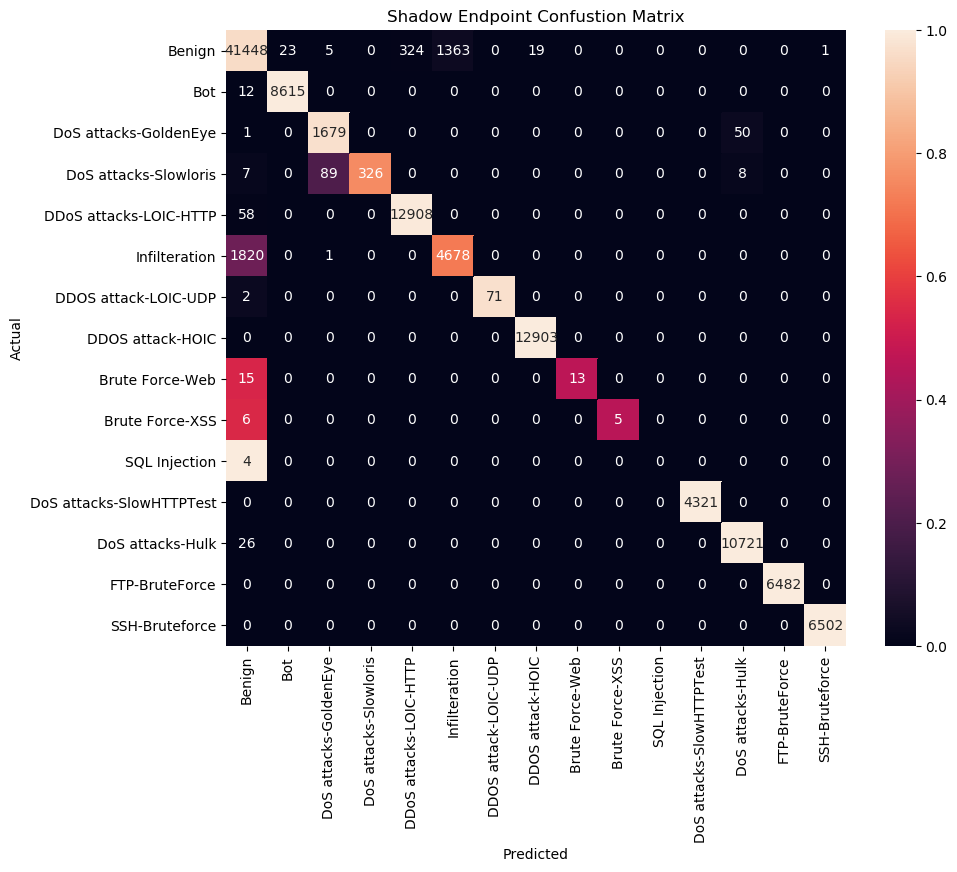

In [687]:
fig, ax = plt.subplots(figsize=(10,8))
cm = confusion_matrix(proddf['Target'],proddf['Prod'])
normalized_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, ax=ax, annot=cm, fmt='',xticklabels=class_list,yticklabels=class_list)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Shadow Endpoint Confustion Matrix')
plt.show()

##### We can see that our shadow model performs better on our validation data than the producion model, so let's promote the shadow to production.

In [639]:
sm_client.stop_inference_experiment(
    Name=shadowtestname,
    ModelVariantActions={
        'Shadow-01': 'Promote',
        'AllTraffic': 'Remove'
    },
    DesiredState='Completed',
    Reason='Variant performed better in validation'
)

{'InferenceExperimentArn': 'arn:aws:sagemaker:us-east-1:431615879134:inference-experiment/shadowinferencetestexistingep',
 'ResponseMetadata': {'RequestId': '713766ac-04a0-43d2-ac7c-7227ca887a40',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '713766ac-04a0-43d2-ac7c-7227ca887a40',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '120',
   'date': 'Tue, 14 Feb 2023 16:42:26 GMT'},
  'RetryAttempts': 0}}

In [640]:
# Here we show that the shadow model is now deployed to production
sm_client.describe_endpoint(EndpointName = predictor.endpoint_name)

{'EndpointName': 'sagemaker-xgboost-2023-02-14-16-19-54-139',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:431615879134:endpoint/sagemaker-xgboost-2023-02-14-16-19-54-139',
 'EndpointConfigName': 'ShadowInferenceT-EpConfig-wksrvgYYVsfIPPbQ',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:b5a61741d3d65872d4b5e6090c200ecf8d8c1ca4ea716261f573dcbc49a46485',
     'ResolutionTime': datetime.datetime(2023, 2, 14, 16, 24, 37, 591000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 2,
   'DesiredInstanceCount': 2}],
 'DataCaptureConfig': {'EnableCapture': True,
  'CaptureStatus': 'Started',
  'CurrentSamplingPercentage': 100,
  'DestinationS3Uri': 's3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/datacapture_test/'},
 'E

In [641]:
config = sm_client.create_endpoint_config(
    EndpointConfigName='previousModel',
    ProductionVariants=[{
        'VariantName': 'AllTraffic',
        'ModelName': model_name1,
        'InitialInstanceCount': 2,
        'InstanceType': 'ml.m5.xlarge',
    }]
)

In [642]:
sm_client.update_endpoint(EndpointName=predictor.endpoint_name, EndpointConfigName='previousModel')

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:431615879134:endpoint/sagemaker-xgboost-2023-02-14-16-19-54-139',
 'ResponseMetadata': {'RequestId': 'd91b8a44-3422-4ec5-b6c2-511d21311c8d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'd91b8a44-3422-4ec5-b6c2-511d21311c8d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '109',
   'date': 'Tue, 14 Feb 2023 16:42:27 GMT'},
  'RetryAttempts': 0}}

##### Calling describe will show us that the endpoint status is updating. Once the update is complete we can run describe again to see the new config

In [643]:
# Here we will see that the endpoint status is updating as Sagemaker updates our config with zero downtime
sm_client.describe_endpoint(EndpointName = predictor.endpoint_name)

{'EndpointName': 'sagemaker-xgboost-2023-02-14-16-19-54-139',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:431615879134:endpoint/sagemaker-xgboost-2023-02-14-16-19-54-139',
 'EndpointConfigName': 'ShadowInferenceT-EpConfig-wksrvgYYVsfIPPbQ',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:b5a61741d3d65872d4b5e6090c200ecf8d8c1ca4ea716261f573dcbc49a46485',
     'ResolutionTime': datetime.datetime(2023, 2, 14, 16, 24, 37, 591000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 2,
   'DesiredInstanceCount': 2}],
 'DataCaptureConfig': {'EnableCapture': True,
  'CaptureStatus': 'Started',
  'CurrentSamplingPercentage': 100,
  'DestinationS3Uri': 's3://sagemaker-us-east-1-431615879134/xgboost-webtraffic/datacapture_test/'},
 'E

##### Finally, let's gracefully stop the deployed endpoint.

## Clean Up

In [644]:
#predictor.delete_endpoint()
sm_client.delete_inference_experiment(
    Name=shadowtestname
)
sm_client.delete_endpoint(EndpointName=predictor.endpoint_name)

ClientError: An error occurred (ValidationException) when calling the DeleteInferenceExperiment operation: Cannot delete InferenceExperiment with status Stopping.

# References

* A Realistic Cyber Defense Dataset (CSE-CIC-IDS2018) - https://registry.opendata.aws/cse-cic-ids2018/
* AIM362 - Re:Invent 2019 SageMaker Debugger and Model Monitor - https://github.com/aws-samples/reinvent2019-aim362-sagemaker-debugger-model-monitor